# GAN implementation

## Data generation and preprocessing

In [163]:
from collections import deque
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# import classical libraries
%matplotlib inline
%pylab inline

# avoid warnings
import warnings
warnings.filterwarnings("ignore")

# figure size
rcParams['figure.figsize'] = (16, 9)

# print only 2 decimals
set_printoptions(precision=2)

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Lorenz-63 dynamical model
def Lorenz_63(x, dx, sigma, rho, beta):
    dx = zeros((3))
    dx[0] = sigma*(x[1]-x[0])
    dx[1] = x[0]*(rho-x[2])-x[1]
    dx[2] = x[0]*x[1] - beta*x[2]
    return dx

In [4]:
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

# define the parameters
x0 = array([8,0,30]) # initial condition
dt = 0.001 # integration time step
T = 100 # number of Lorenz-63 times
sigma = 10
rho = 28
beta = 8/3

# generate the Lorenz-63 system
x = odeint(Lorenz_63, x0, arange(0.01,T,dt), args=(sigma, rho, beta))
time = arange(0.01, T, dt)

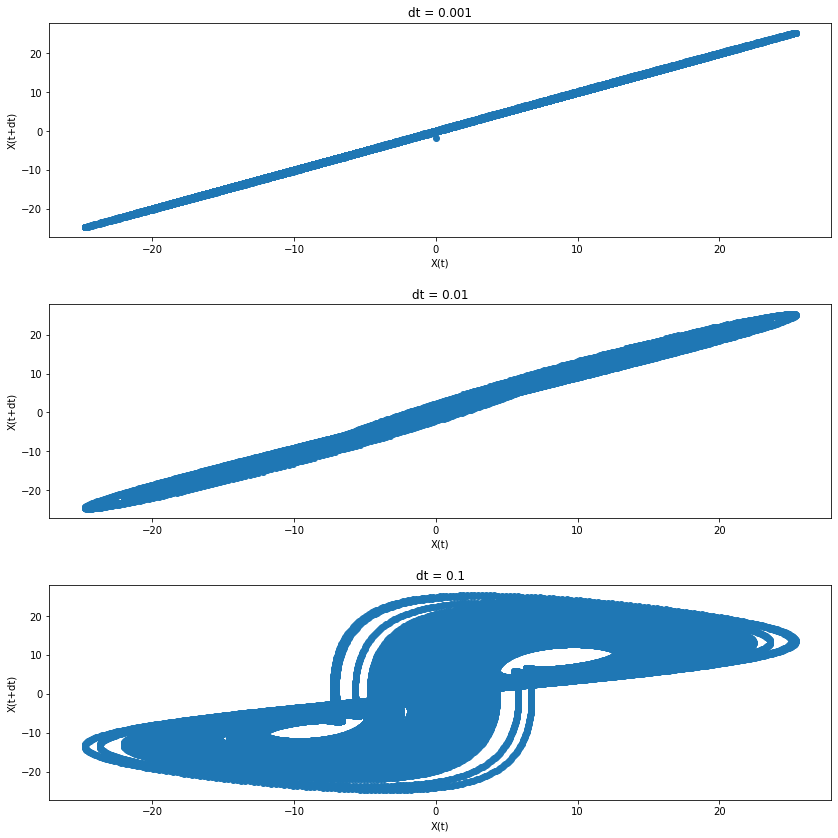

In [7]:
dt_vec = [0.001, 0.01, 0.1]

i = 1

x_ = odeint(Lorenz_63, x0, arange(0.01,T,dt), args=(sigma, rho, beta))

fig = plt.figure(figsize=(12,12))

for dt in dt_vec:
    
    xtplus = deque(x[:,1])
    xtplus.rotate(int(dt/dt_vec[0]))

    xtplus = np.array(list(xtplus))
    np.shape(xtplus)
    
    subplot(3,1,i)
    plt.scatter(x[:,1],xtplus)
    plt.title('dt = '+str(dt))
    plt.xlabel('X(t)')
    plt.ylabel('X(t+dt)')
    i += 1
    
fig.tight_layout(pad = 2)

In [117]:
def generate_data(N,l):
    
    #Model parameters
    dt = 0.001 # integration time step
    sigma = 10
    rho = 28
    beta = 8/3
    #l = int((T-dt)/dt)
    T = dt*(l+1)

    X = np.zeros((N,3*l))
    
    for n in range(N):    

        x0 = [np.random.randn(), np.random.randn(), np.random.randn()]

        # generate the Lorenz-63 system
        x = odeint(Lorenz_63, x0, arange(dt,T,dt), args=(sigma, rho, beta))
        X[n,...] = np.ndarray.flatten(x)
    return X

In [167]:
N = 1000
X = generate_data(N,100)

X_train, X_test = train_test_split(X, test_size=0.33, random_state=42)

## Create model

In [19]:
import keras
from keras.layers import Dense, Dropout, Input, Conv2D
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.optimizers import Adam

In [ ]:
class gan():
    
    def __init__(self):
        create_generator()
    
    def create_generator(self):
        
        self.generator=Sequential()
        self.generator.add(Dense(units=256,input_dim=300, activation='selu'))

        self.generator.add(Dense(units=256, activation='selu'))

        self.generator.add(Dense(units=256, activation='selu'))

        self.generator.add(Dense(units=300, activation='selu'))

        self.generator.compile(loss='mean_squared_error', optimizer='adam')

In [20]:
def create_generator():
    generator=Sequential()
    generator.add(Dense(units=256,input_dim=300, activation='selu'))
    
    generator.add(Dense(units=256, activation='selu'))

    generator.add(Dense(units=256, activation='selu'))
    
    generator.add(Dense(units=300, activation='selu'))
    
    generator.compile(loss='mean_squared_error', optimizer='adam')
    return generator
g=create_generator()
g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 256)               77056     
_________________________________________________________________
dense_20 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_21 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_22 (Dense)             (None, 300)               77100     
Total params: 285,740
Trainable params: 285,740
Non-trainable params: 0
_________________________________________________________________


In [21]:
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=256,input_dim=300, activation='selu'))
    
    discriminator.add(Dense(units=256, activation='selu'))
    
    discriminator.add(Dense(units=256, activation='selu'))

    discriminator.add(Dense(units=1, activation='sigmoid'))

    
    discriminator.compile(loss='binary_crossentropy', optimizer='adam')
    return discriminator
d=create_discriminator()
d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 256)               77056     
_________________________________________________________________
dense_24 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_25 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 257       
Total params: 208,897
Trainable params: 208,897
Non-trainable params: 0
_________________________________________________________________


In [97]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(300,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
gan = create_gan(d,g)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 300)               0         
_________________________________________________________________
sequential_9 (Sequential)    multiple                  285740    
_________________________________________________________________
sequential_10 (Sequential)   multiple                  208897    
Total params: 494,637
Trainable params: 285,740
Non-trainable params: 208,897
_________________________________________________________________


In [171]:
def create_and_train_gan(X_train, epochs=1, batch_size=128):

    #Loading the data
    batch_count = int((X_train.shape[0] / batch_size))+1
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    loss_list = []
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        loss = 0
        
        idx = np.random.randint(0,X_train.shape[0],X_train.shape[0])
        
        for _ in tqdm(range(batch_count)):
                        
            # Real trajectories
            real_trajectory = X_train[idx[batch_size*_:batch_size*_+batch_size,...]]
            
            N = np.shape(real_trajectory)[0]#we now use N instead of batch_size, as the last batch
                                            #may be smaller than the batch size

            #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [N, 300])
 
            generated_trajectory = generator.predict(noise)#.reshape(N,100,3)
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([real_trajectory, generated_trajectory], axis=0)
                        
            # Labels for generated and real data
            y_dis=np.zeros(2*N)
            y_dis[:N]= 1 #0.9bat
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [N, 300])
            y_gen = np.ones(N)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            loss = loss + gan.train_on_batch(noise, y_gen)
        loss_list.append(loss)
    return gan, loss_list
        #if e == 1 or e % 20 == 0:
           
             #plot_generated_images(e, generator)
            

## Train model

In [172]:
gan,loss = training(X_train,10)





  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1






 17%|█▋        | 1/6 [00:18<01:30, 18.04s/it]



 50%|█████     | 3/6 [00:18<00:37, 12.65s/it]



 83%|████████▎ | 5/6 [00:18<00:08,  8.88s/it]



100%|██████████| 6/6 [00:18<00:00,  3.07s/it]



  0%|          | 0/6 [00:00<?, ?it/s]



 33%|███▎      | 2/6 [00:00<00:00, 12.77it/s]

Epoch 2






 50%|█████     | 3/6 [00:00<00:00, 11.74it/s]



 83%|████████▎ | 5/6 [00:00<00:00, 12.48it/s]



100%|██████████| 6/6 [00:00<00:00, 13.91it/s]



  0%|          | 0/6 [00:00<?, ?it/s]



 33%|███▎      | 2/6 [00:00<00:00, 13.70it/s]

Epoch 3






 67%|██████▋   | 4/6 [00:00<00:00, 13.50it/s]



100%|██████████| 6/6 [00:00<00:00, 14.93it/s]



  0%|          | 0/6 [00:00<?, ?it/s]



 33%|███▎      | 2/6 [00:00<00:00, 12.90it/s]

Epoch 4






 50%|█████     | 3/6 [00:00<00:00, 11.83it/s]



 83%|████████▎ | 5/6 [00:00<00:00, 12.04it/s]



100%|██████████| 6/6 [00:00<00:00, 12.69it/s]



  0%|          | 0/6 [00:00<?, ?it/s]



 33%|███▎      | 2/6 [00:00<00:00, 14.06it/s]

Epoch 5






 50%|█████     | 3/6 [00:00<00:00, 12.39it/s]



 83%|████████▎ | 5/6 [00:00<00:00, 12.71it/s]



100%|██████████| 6/6 [00:00<00:00, 13.72it/s]



  0%|          | 0/6 [00:00<?, ?it/s]



 33%|███▎      | 2/6 [00:00<00:00, 14.20it/s]

Epoch 6






 67%|██████▋   | 4/6 [00:00<00:00, 13.81it/s]



100%|██████████| 6/6 [00:00<00:00, 15.04it/s]



  0%|          | 0/6 [00:00<?, ?it/s]



 33%|███▎      | 2/6 [00:00<00:00, 13.28it/s]

Epoch 7






 67%|██████▋   | 4/6 [00:00<00:00, 13.35it/s]



100%|██████████| 6/6 [00:00<00:00, 14.78it/s]



  0%|          | 0/6 [00:00<?, ?it/s]



 33%|███▎      | 2/6 [00:00<00:00, 14.46it/s]

Epoch 8






 67%|██████▋   | 4/6 [00:00<00:00, 14.13it/s]



100%|██████████| 6/6 [00:00<00:00, 15.31it/s]



  0%|          | 0/6 [00:00<?, ?it/s]



 33%|███▎      | 2/6 [00:00<00:00, 13.05it/s]

Epoch 9






 67%|██████▋   | 4/6 [00:00<00:00, 13.74it/s]



100%|██████████| 6/6 [00:00<00:00, 14.66it/s]



  0%|          | 0/6 [00:00<?, ?it/s]



 33%|███▎      | 2/6 [00:00<00:00, 11.74it/s]

Epoch 10






 67%|██████▋   | 4/6 [00:00<00:00, 12.26it/s]



100%|██████████| 6/6 [00:00<00:00, 13.79it/s]

ValueError: too many values to unpack (expected 2)

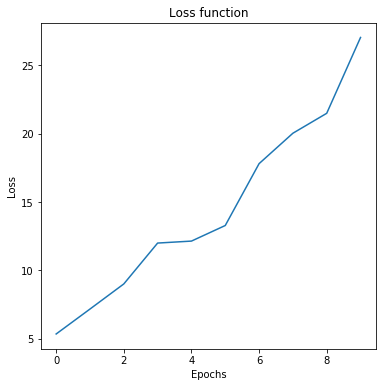

In [173]:
plt.figure(figsize=(6,6))
plt.plot(loss)
plt.title('Loss function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Evaluation

In [ ]:
gan.predict()